In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat



%store -r df 

pd.set_option('display.width', 200)  # Set a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping


print(df)

                                  open        high           low       close       volume  trade_count          vwap
symbol  timestamp                                                                                                   
BTC/USD 2021-01-01 06:00:00  29255.710  29682.2900  28707.560000  29676.7900   848.874030      29639.0  29316.444625
        2021-01-02 06:00:00  29678.340  34200.0000  29555.990000  33769.5200  2144.592516      60152.0  31941.412694
        2021-01-03 06:00:00  33769.520  34812.9300  32300.610000  32908.0200  1838.695433      58725.0  33505.269474
        2021-01-04 06:00:00  32907.360  33496.0300  27900.000000  30441.5700  2711.189503      69226.0  31267.965121
        2021-01-05 06:00:00  30461.840  35851.4200  29927.550000  35063.0000  1756.751333      61880.0  33151.367357
...                                ...         ...           ...         ...          ...          ...           ...
ETH/USD 2025-03-13 05:00:00   1872.600   1919.9550   1822.710049

In [104]:
df_reset = df.copy()

df_reset = df_reset.reset_index()


## Integrate Supertrend for signal confirmation in VWAP Strategy

In [105]:
def calculate_supertrend(df_reset, period=5, multiplier=2.5):
    """Calculate Supertrend indicator"""
    df_reset = df_reset.copy()
    
    # Calculate ATR (Average True Range)
    high_low = df_reset['high'] - df_reset['low']
    high_close = np.abs(df_reset['high'] - df_reset['close'].shift())
    low_close = np.abs(df_reset['low'] - df_reset['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()
    
    # Calculate basic upper and lower bands
    hl2 = (df_reset['high'] + df_reset['low']) / 2
    upper_band = hl2 + (multiplier * atr)
    lower_band = hl2 - (multiplier * atr)
    
    # Initialize Supertrend
    supertrend = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    final_upper = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    final_lower = pd.Series(np.zeros(len(df_reset)), index=df_reset.index)
    
    # Calculate Supertrend
    for i in range(period, len(df_reset)):
        if df_reset['close'].iloc[i-1] <= final_upper.iloc[i-1]:
            final_upper.iloc[i] = min(upper_band.iloc[i], final_upper.iloc[i-1])
        else:
            final_upper.iloc[i] = upper_band.iloc[i]
        if df_reset['close'].iloc[i-1] >= final_lower.iloc[i-1]:
            final_lower.iloc[i] = max(lower_band.iloc[i], final_lower.iloc[i-1])
        else:
            final_lower.iloc[i] = lower_band.iloc[i]
        if (supertrend.iloc[i-1] > 0 and df_reset['close'].iloc[i] > final_upper.iloc[i-1]) or \
           (supertrend.iloc[i-1] <= 0 and df_reset['close'].iloc[i] > final_upper.iloc[i]):
            supertrend.iloc[i] = 1  # Uptrend
        elif (supertrend.iloc[i-1] < 0 and df_reset['close'].iloc[i] < final_lower.iloc[i-1]) or \
             (supertrend.iloc[i-1] >= 0 and df_reset['close'].iloc[i] < final_lower.iloc[i]):
            supertrend.iloc[i] = -1  # Downtrend
        else:
            supertrend.iloc[i] = supertrend.iloc[i-1]
    
    return supertrend

def generate_vwap_super_signals(df_reset, supertrend_period=5, supertrend_multiplier=2.5):
    # Reset index to work with symbol and timestamp as columns
    df_reset = df_reset.copy()  # Ensure we don’t modify the input
    df_reset = df_reset.reset_index()
    
    # Create signals dataframe
    signals = pd.DataFrame(index=df_reset.index)
    signals['symbol'] = df_reset['symbol']
    signals['timestamp'] = df_reset['timestamp']
    signals['close'] = df_reset['close']
    signals['vwap'] = df_reset['vwap']
    
    # Calculate Supertrend for confirmation
    required_cols = ['high', 'low', 'close']
    supertrend = (df_reset.groupby('symbol')[required_cols]
                  .apply(lambda x: calculate_supertrend(x, supertrend_period, supertrend_multiplier),
                         include_groups=False)
                  .reset_index(level=0, drop=True))
    signals['supertrend'] = supertrend
    
    # Simplified VWAP signals (no crossover, just position relative to VWAP)
    signals['raw_signal'] = 0
    signals.loc[signals['close'] > signals['vwap'], 'raw_signal'] = 1  # Buy
    signals.loc[signals['close'] < signals['vwap'], 'raw_signal'] = -1  # Sell
    
    # Apply Supertrend confirmation
    signals['signal'] = 0
    signals.loc[(signals['raw_signal'] == 1) & 
                (signals['supertrend'] > 0), 'signal'] = 1  # Buy only if Supertrend bullish
    signals.loc[(signals['raw_signal'] == -1) & 
                (signals['supertrend'] < 0), 'signal'] = -1  # Sell only if Supertrend bearish
    
    # Handle symbol boundaries
    signals['symbol_change'] = signals['symbol'] != signals['symbol'].shift(1)
    signals.loc[signals['symbol_change'], 'supertrend'] = np.nan
    signals.loc[signals['symbol_change'], 'signal'] = 0
    
    # Clean up
    signals = signals.drop(['symbol_change', 'raw_signal'], axis=1)
    signals = signals.set_index(['symbol', 'timestamp'])
    
    return signals

# Generate signals with Supertrend confirmation
signal_df = generate_vwap_super_signals(df_reset, supertrend_period=5, supertrend_multiplier=2.5)

# Reset index to align them
df_reset = df_reset.reset_index(drop=True)
signal_df = signal_df.reset_index(drop=True)

# Now join them
result_df = df_reset.join(signal_df[['signal', 'supertrend']])

# Display results
print("\nSample of results with VWAP and Supertrend signals (Simplified VWAP Rule):")
print(result_df[['close', 'vwap', 'supertrend', 'signal']].head(10))

# Count signals by symbol
print("\nSignal counts by symbol:")
print(result_df.groupby('symbol')['signal'].value_counts())

# Calculate signal frequency
total_signals = result_df['signal'].abs().sum()
total_periods = len(result_df)
print(f"\nSignal frequency: {total_signals/total_periods:.4f} ({total_signals} signals in {total_periods} periods)")


Sample of results with VWAP and Supertrend signals (Simplified VWAP Rule):
      close          vwap  supertrend  signal
0  29676.79  29316.444625         NaN       0
1  33769.52  31941.412694         0.0       0
2  32908.02  33505.269474         0.0       0
3  30441.57  31267.965121         0.0       0
4  35063.00  33151.367357         0.0       0
5  37485.27  35720.825762         0.0       0
6  38009.79  38472.947353         0.0       0
7  39379.24  40360.705381         0.0       0
8  40547.42  40539.899845         0.0       0
9  34860.75  37212.352596         0.0       0

Signal counts by symbol:
symbol   signal
BTC/USD   0        753
          1        416
         -1        368
ETH/USD   0        757
         -1        408
          1        372
Name: count, dtype: int64

Signal frequency: 0.5088 (1564 signals in 3074 periods)


In [106]:
print(result_df)
%store result_df

       symbol           timestamp       open        high           low       close       volume  trade_count          vwap  signal  supertrend
0     BTC/USD 2021-01-01 06:00:00  29255.710  29682.2900  28707.560000  29676.7900   848.874030      29639.0  29316.444625       0         NaN
1     BTC/USD 2021-01-02 06:00:00  29678.340  34200.0000  29555.990000  33769.5200  2144.592516      60152.0  31941.412694       0         0.0
2     BTC/USD 2021-01-03 06:00:00  33769.520  34812.9300  32300.610000  32908.0200  1838.695433      58725.0  33505.269474       0         0.0
3     BTC/USD 2021-01-04 06:00:00  32907.360  33496.0300  27900.000000  30441.5700  2711.189503      69226.0  31267.965121       0         0.0
4     BTC/USD 2021-01-05 06:00:00  30461.840  35851.4200  29927.550000  35063.0000  1756.751333      61880.0  33151.367357       0         0.0
...       ...                 ...        ...         ...           ...         ...          ...          ...           ...     ...         ...

# Defining a Backtest Function

In [107]:
# --- Backtest Function ---
def backtest_strategy(result_df, initial_capital=10000, transaction_cost=0.001):
    symbols = result_df.index.get_level_values('symbol').unique()
    performance = {}
    
    for symbol in symbols:
        df_symbol = result_df.xs(symbol, level='symbol').copy()
        df_symbol['returns'] = df_symbol['close'].pct_change()
        df_symbol['strategy_returns'] = 0.0
        df_symbol['position'] = 0
        
        current_position = 0
        for i in range(1, len(df_symbol)):
            signal = df_symbol['signal'].iloc[i]
            prev_position = df_symbol['position'].iloc[i-1]
            
            if signal == 1 and current_position == 0:  # Enter long
                current_position = 1
            elif signal == -1 and current_position == 0:  # Enter short
                current_position = -1
            elif signal != 0 and current_position != 0:  # Exit on opposite signal
                current_position = 0
            
            df_symbol.loc[df_symbol.index[i], 'position'] = current_position
            if current_position != prev_position:  # Trade occurred
                df_symbol.loc[df_symbol.index[i], 'strategy_returns'] = -transaction_cost
            if current_position != 0:
                df_symbol.loc[df_symbol.index[i], 'strategy_returns'] += current_position * df_symbol['returns'].iloc[i]
        
        
        # Calculate performance metrics

        # Calculate capital growth over time
        df_symbol['capital'] = initial_capital * (1 + df_symbol['strategy_returns']).cumprod()

        
        total_return = (df_symbol['capital'].iloc[-1] / initial_capital) - 1
        sharpe_ratio = (df_symbol['strategy_returns'].mean() / df_symbol['strategy_returns'].std()) * np.sqrt(252)
        max_drawdown = (df_symbol['capital'].cummax() - df_symbol['capital']).max() / df_symbol['capital'].cummax().max()
        # Number of Trades
        number_of_trades = ((df_symbol['position'] != df_symbol['position'].shift()) & 
                           (df_symbol['position'] != 0)).sum()
    
        # Sortino Ratio
        downside_returns = df_symbol['strategy_returns'][df_symbol['strategy_returns'] < 0]
        downside_deviation = downside_returns.std() if not downside_returns.empty else 0
        sortino_ratio = (df_symbol['strategy_returns'].mean() / downside_deviation) * np.sqrt(252) if downside_deviation != 0 else 0
        
        max_drawdown = (df_symbol['capital'].cummax() - df_symbol['capital']).max() / df_symbol['capital'].cummax().max()

         # Buy-and-Hold Return
        initial_price = df_symbol['close'].iloc[0]
        final_price = df_symbol['close'].iloc[-1]
        buy_hold_return = (final_price / initial_price) - 1


        performance[symbol] = {
            'Total Return': total_return,
            'Sharpe Ratio': sharpe_ratio if not pd.isna(sharpe_ratio) else 0,
            'Sortino Ratio': sortino_ratio if not pd.isna(sortino_ratio) else 0,
            'Max Drawdown': max_drawdown,
            'Number of Trades': number_of_trades,
            'buy_hold_return': buy_hold_return,
            'Capital': df_symbol['capital']
        }
        
        print(f"\nPerformance for {symbol}:")
        print(pd.Series(performance[symbol]))
    
    return performance


## Running Backtest for VWAP + Supertrend

In [108]:
# Generate VWAP + Supertrend signals
supertrend_signal_df = generate_vwap_super_signals(df_reset, supertrend_period=5, supertrend_multiplier=2.5)

# Reset index to align DataFrames
df_reset = df_reset.reset_index(drop=True)
supertrend_signal_df = supertrend_signal_df.reset_index(drop=True)

# Ensure 'symbol' exists in supertrend_signal_df
if 'symbol' not in supertrend_signal_df.columns:
    supertrend_signal_df['symbol'] = df_reset['symbol']

# Concatenate the DataFrames column-wise
supertrend_result_df = pd.concat([df_reset, supertrend_signal_df[['signal', 'supertrend']]], axis=1)

# Ensure 'symbol' is set as an index (if required by backtest function)
if 'symbol' in supertrend_result_df.columns:
    supertrend_result_df = supertrend_result_df.set_index('symbol', append=True)

# # Debugging Outputs
# print("df_reset index:", df_reset.index.names)
# print("supertrend_signal_df index:", supertrend_signal_df.index.names)
# print("supertrend_result_df index:", supertrend_result_df.index.names)

# print("df_reset columns:", df_reset.columns)
# print("supertrend_signal_df columns:", supertrend_signal_df.columns)

# # Print signal counts
# print("\nSignal Counts for VWAP + Supertrend:")
# print(supertrend_result_df.groupby('symbol')['signal'].value_counts())

# Backtest Strategy
print("\nBacktest Results for VWAP + Supertrend:")
performance_supertrend = backtest_strategy(supertrend_result_df)



Backtest Results for VWAP + Supertrend:

Performance for BTC/USD:
Total Return                                                 7.752036
Sharpe Ratio                                                 1.193142
Sortino Ratio                                                1.667854
Max Drawdown                                                 0.133591
Number of Trades                                                  392
buy_hold_return                                              1.796103
Capital             0       10000.000000
1       10000.000000
2   ...
dtype: object

Performance for ETH/USD:
Total Return                                                 9.239247
Sharpe Ratio                                                 1.061096
Sortino Ratio                                                1.431439
Max Drawdown                                                 0.192397
Number of Trades                                                  390
buy_hold_return                                      

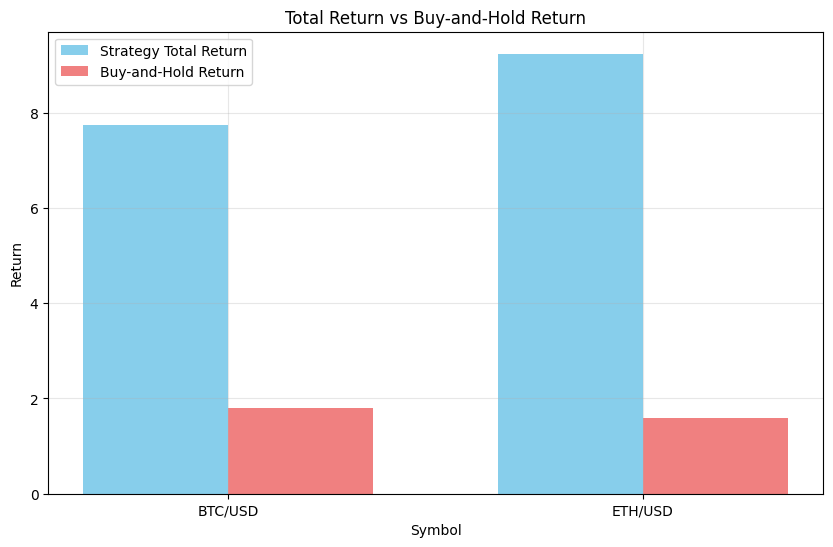

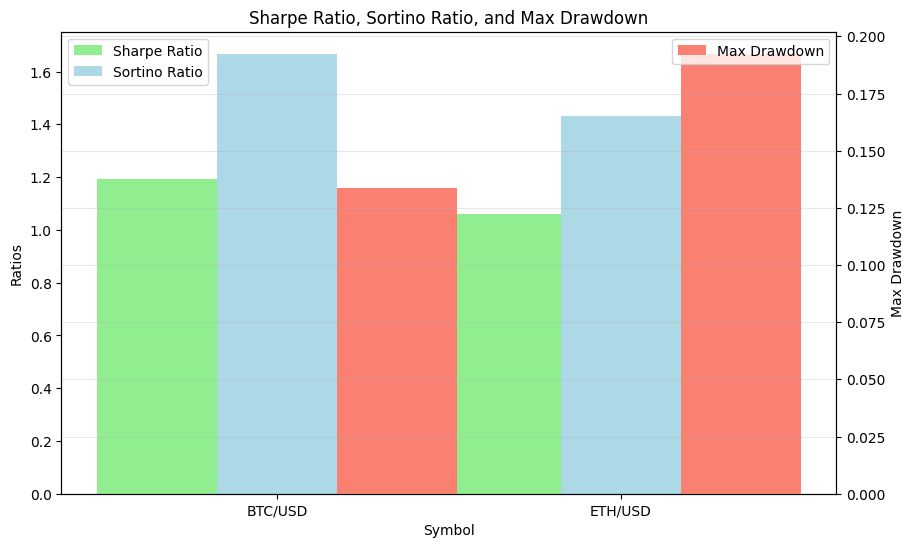

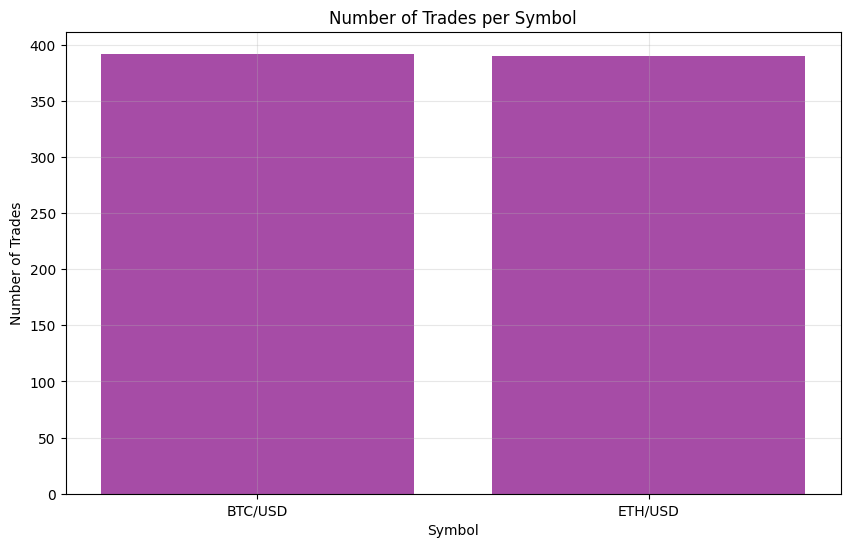

In [109]:
# --- Visualize Performance Metrics ---
# Convert performance dictionary to DataFrame for plotting
performance_df = pd.DataFrame(performance_supertrend).T.reset_index()
performance_df.columns = ['Symbol', 'Total Return', 'Sharpe Ratio', 'Sortino Ratio', 
                         'Max Drawdown', 'Number of Trades', 'Buy-and-Hold Return', 'Capital']

# # Set style for better visuals
# plt.style.use('seaborn')
# sns.set_palette("husl")

# 1. Bar Chart for Total Return and Buy-and-Hold Return
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(performance_df['Symbol']))

plt.bar(index, performance_df['Total Return'], bar_width, label='Strategy Total Return', color='skyblue')
plt.bar(index + bar_width, performance_df['Buy-and-Hold Return'], bar_width, label='Buy-and-Hold Return', color='lightcoral')

plt.xlabel('Symbol')
plt.ylabel('Return')
plt.title('Total Return vs Buy-and-Hold Return')
plt.xticks(index + bar_width / 2, performance_df['Symbol'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Bar Chart for Sharpe Ratio, Sortino Ratio, and Max Drawdown
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(index, performance_df['Sharpe Ratio'], bar_width, label='Sharpe Ratio', color='lightgreen')
ax1.bar(index + bar_width, performance_df['Sortino Ratio'], bar_width, label='Sortino Ratio', color='lightblue')
ax2 = ax1.twinx()
ax2.bar(index + 2 * bar_width, performance_df['Max Drawdown'], bar_width, label='Max Drawdown', color='salmon')

ax1.set_xlabel('Symbol')
ax1.set_ylabel('Ratios', color='black')
ax2.set_ylabel('Max Drawdown', color='black')
plt.title('Sharpe Ratio, Sortino Ratio, and Max Drawdown')
plt.xticks(index + bar_width, performance_df['Symbol'])
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Line Plot for Capital Growth (if stored in backtest)
# Note: Modify backtest_strategy to store 'capital' in df_symbol if you want this plot
# for symbols in Symbol:
#     performance_df['capital'].plot(label=Symbol)
# plt.title('Capital Growth Over Time')
# plt.xlabel('Time')
# plt.ylabel('Capital ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# 4. Number of Trades (Simple Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Symbol'], performance_df['Number of Trades'], color='purple', alpha=0.7)
plt.xlabel('Symbol')
plt.ylabel('Number of Trades')
plt.title('Number of Trades per Symbol')
plt.grid(True, alpha=0.3)
plt.show()



### Capital growth for each symbol

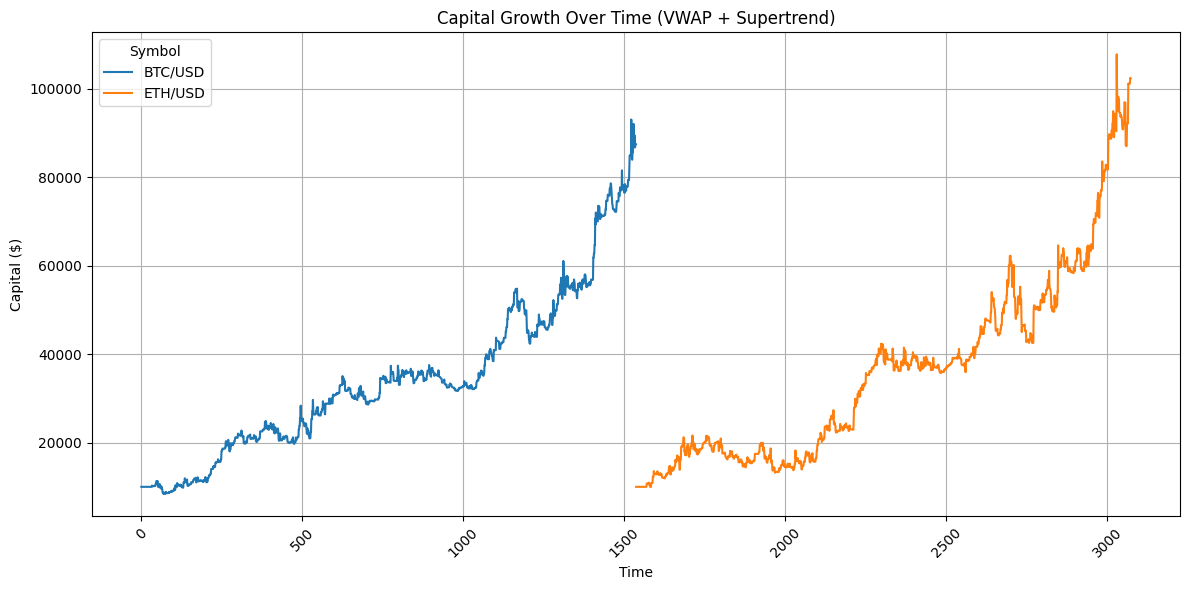

In [110]:
import matplotlib.pyplot as plt

# Run the backtest
#performance_supertrend = backtest_strategy(supertrend_result_df)

# Plot capital growth for each symbol
plt.figure(figsize=(12, 6))
for symbol, data in performance_supertrend.items():
    capital_series = data['Capital']
    plt.plot(capital_series.index, capital_series, label=symbol)

plt.title('Capital Growth Over Time (VWAP + Supertrend)')
plt.xlabel('Time')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend(title='Symbol')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [111]:


# Run the backtest
#performance_supertrend = backtest_strategy(supertrend_result_df)

# Combine all symbols' capital data into a single DataFrame
all_capital_data = []
for symbol, data in performance_supertrend.items():
    capital_series = data['Capital'].reset_index()
    capital_series['Symbol'] = symbol
    all_capital_data.append(capital_series)

# Concatenate into a single DataFrame
combined_df = pd.concat(all_capital_data)
combined_df.columns = ['Time', 'Capital', 'Symbol']  # Adjust 'Time' if your index name differs

# Plot with Plotly Express
fig = px.line(combined_df, x='Time', y='Capital', color='Symbol',
              title='Capital Growth Over Time (VWAP + Supertrend)',
              labels={'Time': 'Time', 'Capital': 'Capital ($)'})
fig.update_layout(
    xaxis={'showgrid': True},  # Show grid on x-axis
    yaxis={'showgrid': True}   # Show grid on y-axis
)
fig.show()

## EDA on Signals

               close           vwap   supertrend
count    3074.000000    3074.000000  3072.000000
mean    23808.263887   23793.423311    -0.014323
std     26307.854893   26284.058374     0.989586
min       733.650000     731.807780    -1.000000
25%      2286.269000    2288.598051    -1.000000
50%     10304.475000   10337.574865     0.000000
75%     41555.725875   41463.215311     1.000000
max    106855.344500  106708.386342     1.000000


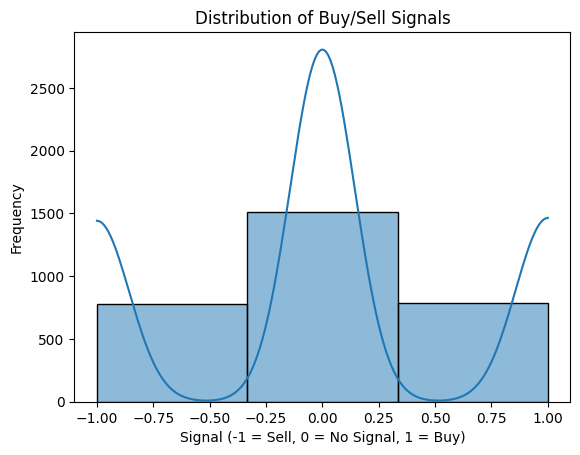

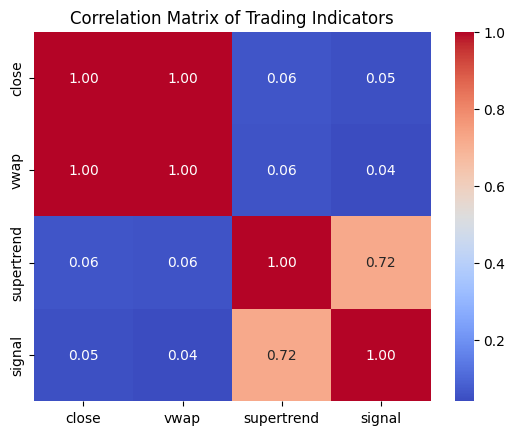

In [112]:
# Check data statistics
print(result_df[['close', 'vwap', 'supertrend']].describe())

# Check signal distribution
sns.histplot(result_df['signal'], bins=3, kde=True)
plt.title("Distribution of Buy/Sell Signals")
plt.xlabel("Signal (-1 = Sell, 0 = No Signal, 1 = Buy)")
plt.ylabel("Frequency")
plt.show()

# Correlation matrix
corr_matrix = result_df[['close', 'vwap', 'supertrend', 'signal']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Trading Indicators")
plt.show()


# Visualize Trade Signals


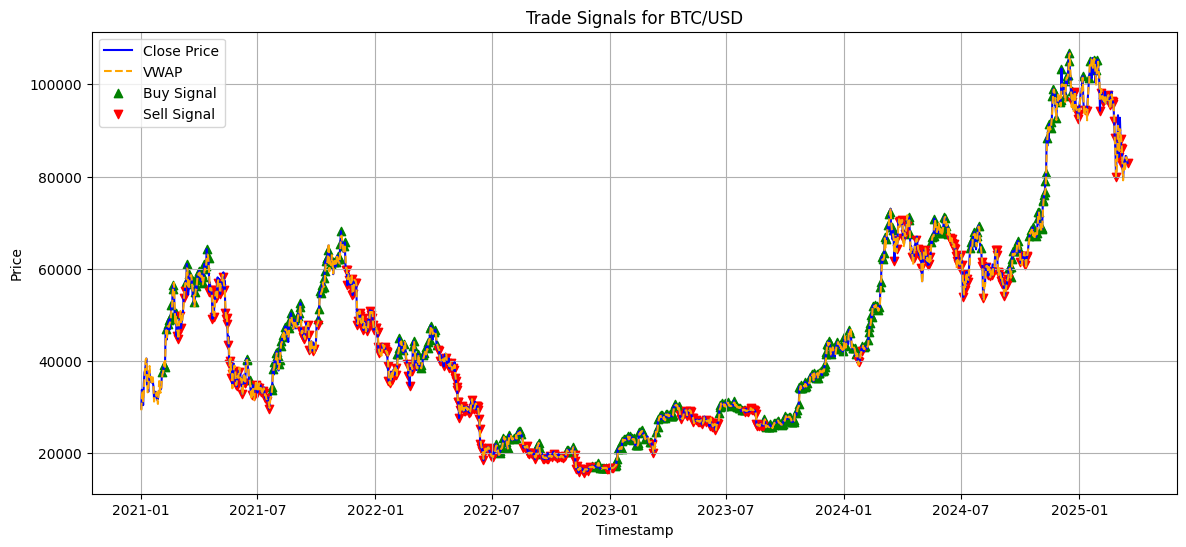

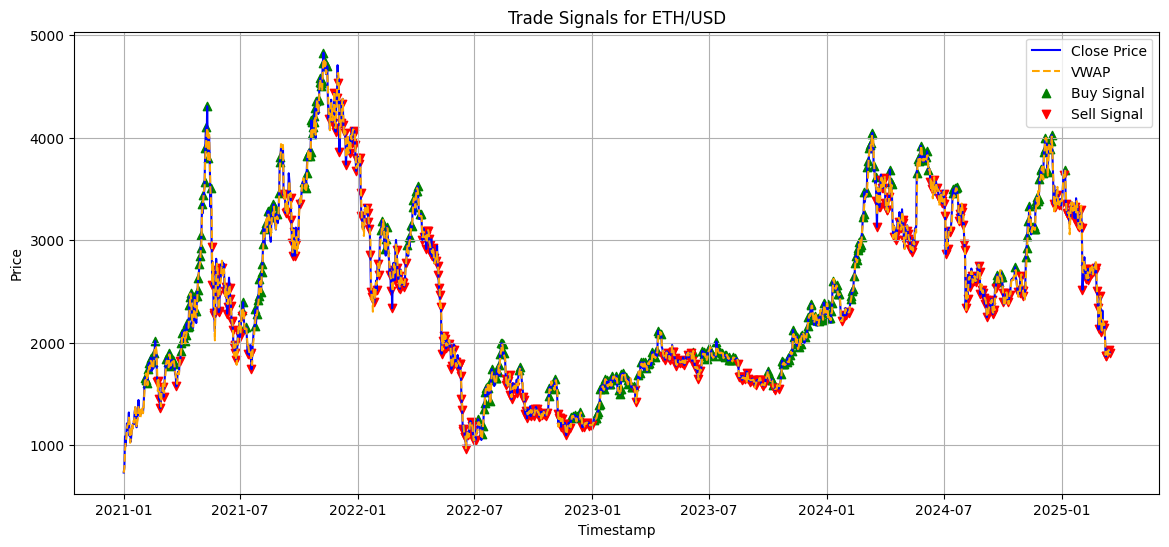

In [113]:
def plot_signals(result_df, symbol):
    asset_df = result_df[result_df['symbol'] == symbol].copy()
    
    plt.figure(figsize=(14, 6))
    plt.plot(asset_df['timestamp'], asset_df['close'], label="Close Price", color="blue")
    plt.plot(asset_df['timestamp'], asset_df['vwap'], label="VWAP", color="orange", linestyle="dashed")

    # Plot buy signals
    buy_signals = asset_df[asset_df['signal'] == 1]
    plt.scatter(buy_signals['timestamp'], buy_signals['close'], label="Buy Signal", color="green", marker="^", alpha=1)

    # Plot sell signals
    sell_signals = asset_df[asset_df['signal'] == -1]
    plt.scatter(sell_signals['timestamp'], sell_signals['close'], label="Sell Signal", color="red", marker="v", alpha=1)

    plt.title(f"Trade Signals for {symbol}")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Plot for BTC/USD and ETH/USD
plot_signals(result_df, 'BTC/USD')
plot_signals(result_df, 'ETH/USD')
